In [1]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

# config

In [2]:
BASE_DIR = "/working/"
EXP_NAME = "exp014"
OUTPUT_DIR = os.path.join(BASE_DIR, "output", EXP_NAME)

# metric

In [3]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        # print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

In [9]:
def opening(mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=3)
    mask = cv2.dilate(mask, kernel, iterations=3)
    return mask

def closing(mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=3)
    mask = cv2.erode(mask, kernel, iterations=3)
    return mask

---
# OOF SCORE CHECK

/working/output/exp014/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


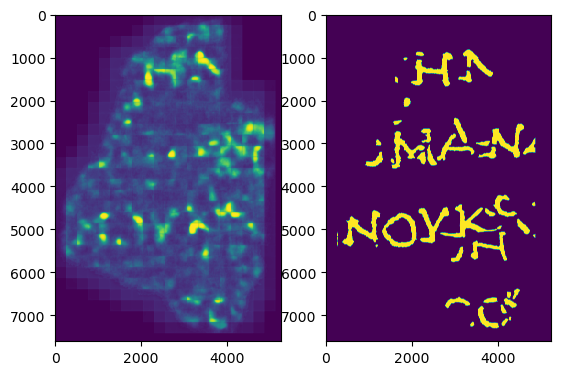

/working/output/exp014/imgs/fold1_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


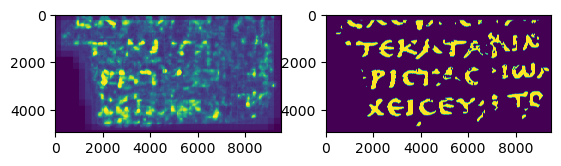

/working/output/exp014/imgs/fold2_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


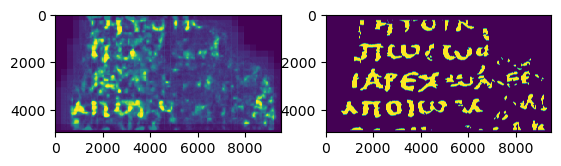

/working/output/exp014/imgs/fold3_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


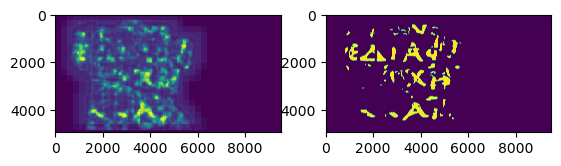

/working/output/exp014/imgs/fold4_average_slice555_valid_pred_img.png
(8181, 6330)
(8181, 6330)


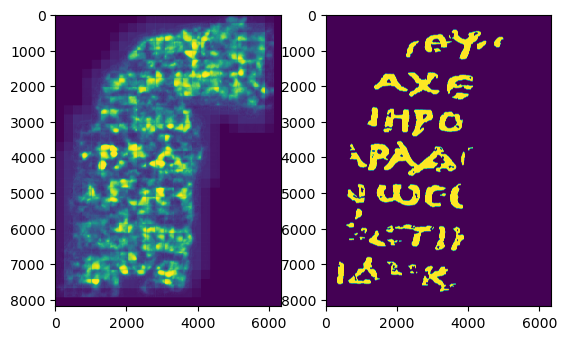

CPU times: user 17.4 s, sys: 14.4 s, total: 31.8 s
Wall time: 29.7 s


In [5]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

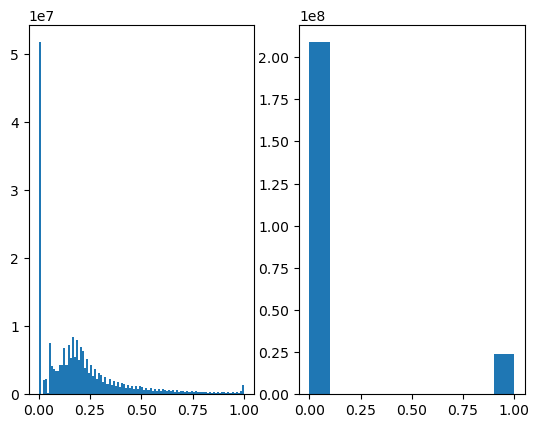

th=0.10, dice=0.1854
th=0.15, dice=0.2177
th=0.20, dice=0.2684
th=0.25, dice=0.3237
th=0.30, dice=0.3685
th=0.35, dice=0.4080
th=0.40, dice=0.4401
th=0.45, dice=0.4703
th=0.50, dice=0.4987
th=0.55, dice=0.5186
th=0.60, dice=0.5293
th=0.65, dice=0.5341
th=0.70, dice=0.5313
th=0.75, dice=0.5170
th=0.80, dice=0.4940
th=0.85, dice=0.4576
th=0.90, dice=0.4044
th=0.95, dice=0.3257
th=1.00, dice=0.1492


In [6]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")

fold[0] slice ave score:0.5541(th=0.897338), auc=0.600000  
fold[1] slice ave score:0.5659(th=0.858590), auc=0.650000  
fold[2] slice ave score:0.5316(th=0.839597), auc=0.600000  
fold[3] slice ave score:0.5648(th=0.926478), auc=0.600000  
fold[4] slice ave score:0.5130(th=0.892056), auc=0.750000  

In [7]:
threshols =[0.60000, 0.650000, 0.60000, 0.60000, 0.75000]
print(np.mean(threshols))

0.64


---
# opening TTA

/working/output/exp014/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


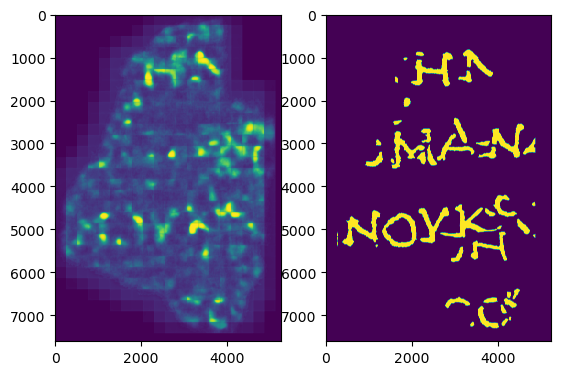

opening
th=0.10, dice=0.1494
th=0.15, dice=0.2109
th=0.20, dice=0.3318
th=0.25, dice=0.3915
th=0.30, dice=0.4142
th=0.35, dice=0.3960
th=0.40, dice=0.3070
th=0.45, dice=0.2374
th=0.50, dice=0.1361
th=0.55, dice=0.0000
th=0.60, dice=0.0000
th=0.65, dice=0.0000
th=0.70, dice=0.0000
th=0.75, dice=0.0000
th=0.80, dice=0.0000
th=0.85, dice=0.0000
th=0.90, dice=0.0000
th=0.95, dice=0.0000
th=1.00, dice=0.0000
closing
th=0.10, dice=0.1403
th=0.15, dice=0.1505
th=0.20, dice=0.1632
th=0.25, dice=0.2173
th=0.30, dice=0.3194
th=0.35, dice=0.3807
th=0.40, dice=0.4278
th=0.45, dice=0.4691
th=0.50, dice=0.5050
th=0.55, dice=0.5349
th=0.60, dice=0.5428
th=0.65, dice=0.5521
th=0.70, dice=0.5490
th=0.75, dice=0.5286
th=0.80, dice=0.4941
th=0.85, dice=0.4329
th=0.90, dice=0.3537
th=0.95, dice=0.2661
th=1.00, dice=0.0807
/working/output/exp014/imgs/fold1_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


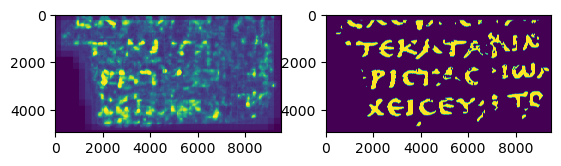

opening
th=0.10, dice=0.1959
th=0.15, dice=0.2340
th=0.20, dice=0.3234
th=0.25, dice=0.4150
th=0.30, dice=0.4497
th=0.35, dice=0.4565
th=0.40, dice=0.4580
th=0.45, dice=0.4148
th=0.50, dice=0.3267
th=0.55, dice=0.2143
th=0.60, dice=0.1666
th=0.65, dice=0.1171
th=0.70, dice=0.0000
th=0.75, dice=0.0000
th=0.80, dice=0.0000
th=0.85, dice=0.0000
th=0.90, dice=0.0000
th=0.95, dice=0.0000
th=1.00, dice=0.0000
closing
th=0.10, dice=0.1802
th=0.15, dice=0.1943
th=0.20, dice=0.2011
th=0.25, dice=0.2193
th=0.30, dice=0.2717
th=0.35, dice=0.3295
th=0.40, dice=0.3799
th=0.45, dice=0.4263
th=0.50, dice=0.4701
th=0.55, dice=0.5037
th=0.60, dice=0.5266
th=0.65, dice=0.5490
th=0.70, dice=0.5567
th=0.75, dice=0.5595
th=0.80, dice=0.5525
th=0.85, dice=0.5135
th=0.90, dice=0.4642
th=0.95, dice=0.3997
th=1.00, dice=0.2223
/working/output/exp014/imgs/fold2_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


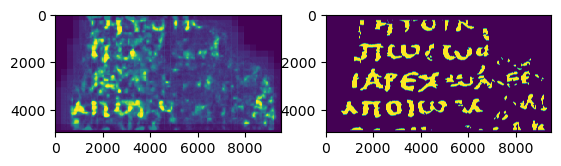

opening
th=0.10, dice=0.2173
th=0.15, dice=0.3118
th=0.20, dice=0.3798
th=0.25, dice=0.4156
th=0.30, dice=0.4513
th=0.35, dice=0.4515
th=0.40, dice=0.4333
th=0.45, dice=0.3660
th=0.50, dice=0.2679
th=0.55, dice=0.2381
th=0.60, dice=0.1977
th=0.65, dice=0.0491
th=0.70, dice=0.0000
th=0.75, dice=0.0000
th=0.80, dice=0.0000
th=0.85, dice=0.0000
th=0.90, dice=0.0000
th=0.95, dice=0.0000
th=1.00, dice=0.0000
closing
th=0.10, dice=0.1950
th=0.15, dice=0.2083
th=0.20, dice=0.2244
th=0.25, dice=0.2783
th=0.30, dice=0.3333
th=0.35, dice=0.3719
th=0.40, dice=0.4020
th=0.45, dice=0.4461
th=0.50, dice=0.4887
th=0.55, dice=0.5120
th=0.60, dice=0.5267
th=0.65, dice=0.5296
th=0.70, dice=0.5299
th=0.75, dice=0.5167
th=0.80, dice=0.4976
th=0.85, dice=0.4803
th=0.90, dice=0.4493
th=0.95, dice=0.3913
th=1.00, dice=0.2260
/working/output/exp014/imgs/fold3_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


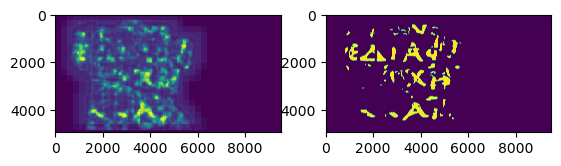

opening
th=0.10, dice=0.1839
th=0.15, dice=0.2805
th=0.20, dice=0.3771
th=0.25, dice=0.4337
th=0.30, dice=0.4733
th=0.35, dice=0.4807
th=0.40, dice=0.4406
th=0.45, dice=0.3422
th=0.50, dice=0.2647
th=0.55, dice=0.1377
th=0.60, dice=0.0624
th=0.65, dice=0.0461
th=0.70, dice=0.0000
th=0.75, dice=0.0000
th=0.80, dice=0.0000
th=0.85, dice=0.0000
th=0.90, dice=0.0000
th=0.95, dice=0.0000
th=1.00, dice=0.0000
closing
th=0.10, dice=0.1507
th=0.15, dice=0.1617
th=0.20, dice=0.1967
th=0.25, dice=0.2577
th=0.30, dice=0.3230
th=0.35, dice=0.3701
th=0.40, dice=0.4193
th=0.45, dice=0.4662
th=0.50, dice=0.5033
th=0.55, dice=0.5301
th=0.60, dice=0.5505
th=0.65, dice=0.5593
th=0.70, dice=0.5639
th=0.75, dice=0.5430
th=0.80, dice=0.5066
th=0.85, dice=0.4329
th=0.90, dice=0.3419
th=0.95, dice=0.2104
th=1.00, dice=0.0451
/working/output/exp014/imgs/fold4_average_slice555_valid_pred_img.png
(8181, 6330)
(8181, 6330)


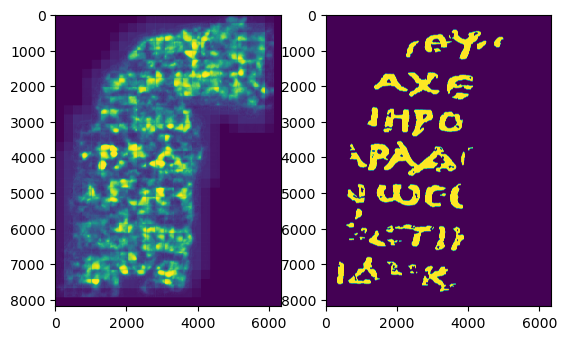

opening
th=0.10, dice=0.2126
th=0.15, dice=0.2517
th=0.20, dice=0.2901
th=0.25, dice=0.3294
th=0.30, dice=0.3754
th=0.35, dice=0.4168
th=0.40, dice=0.4347
th=0.45, dice=0.4614
th=0.50, dice=0.4421
th=0.55, dice=0.3388
th=0.60, dice=0.2245
th=0.65, dice=0.0947
th=0.70, dice=0.0420
th=0.75, dice=0.0000
th=0.80, dice=0.0000
th=0.85, dice=0.0000
th=0.90, dice=0.0000
th=0.95, dice=0.0000
th=1.00, dice=0.0000
closing
th=0.10, dice=0.2005
th=0.15, dice=0.2151
th=0.20, dice=0.2296
th=0.25, dice=0.2477
th=0.30, dice=0.2667
th=0.35, dice=0.2878
th=0.40, dice=0.3065
th=0.45, dice=0.3321
th=0.50, dice=0.3613
th=0.55, dice=0.3886
th=0.60, dice=0.4189
th=0.65, dice=0.4449
th=0.70, dice=0.4713
th=0.75, dice=0.5065
th=0.80, dice=0.5153
th=0.85, dice=0.5190
th=0.90, dice=0.4866
th=0.95, dice=0.3907
th=1.00, dice=0.1449
CPU times: user 1min 40s, sys: 23.4 s, total: 2min 4s
Wall time: 2min 4s


In [44]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    for th in np.array(range(10, 100+1, 5)) / 100:
        pred_binary = (pred_img/255. >= th).astype(np.uint8)
        pred_binary = opening(pred_binary, 65)
        dice = fbeta_numpy((mask_img.flatten()/255.).astype(int), pred_binary.flatten(), beta=0.5)
        print(f"th={th:.2f}, dice={dice:.4f}")
        
    
    for th in np.array(range(10, 100+1, 5)) / 100:
        pred_binary = (pred_img/255. >= th).astype(np.uint8)
        pred_binary = closing(pred_binary, 65)
        dice = fbeta_numpy(mask_img.flatten()/255.).astype(int), pred_binary.flatten(), beta=0.5)
        print(f"th={th:.2f}, dice={dice:.4f}")
 
    # pred_flatten_list.extend(pred_img.flatten())
    # mask_flatten_list.extend(mask_img.flatten())

In [ ]:
pred_flatten_list = []
mask_flatten_list = []
pred = 0.7
for th_ in range(55, 80, 5):
    th = th_ / 100
    for fold in [0,1,2,3,4]:
        pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
        mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
        print(pred_path)
        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        print(pred_img.shape)
        print(mask_img.shape)

        pred_binary = (pred_img/255. >= th).astype(np.uint8)
        pred_binary = closing(pred_binary, 65)
        mask_flatten_list.extend((mask_img.flatten()/255.).astype(int))
        pred_flatten_list.extend(pred_binary.flatten())
    dice = fbeta_numpy(np.array(mask_flatten_list), np.array(pred_flatten_list), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")
    

/working/output/exp014/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)
/working/output/exp014/imgs/fold1_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


: 

: 